[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

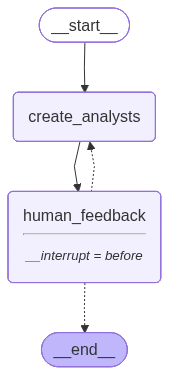

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Input
max_analysts = 4
topic = "The analysis of the ethical requirements and computational power required for singularity/Artifical General Intelligence."
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Institute for Ethical AI Research
Role: Ethics Researcher
Description: Dr. Carter focuses on the ethical implications of developing Artificial General Intelligence (AGI). She is particularly concerned with the moral responsibilities of AI developers and the potential societal impacts of AGI deployment.
--------------------------------------------------
Name: Prof. James Liu
Affiliation: Global Computational Intelligence Lab
Role: Computational Scientist
Description: Prof. Liu specializes in the computational requirements for achieving AGI. His research includes the analysis of hardware advancements and algorithmic efficiency necessary for the singularity.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Center for AI Policy and Governance
Role: Policy Analyst
Description: Ms. Thompson examines the regulatory frameworks needed to govern the development and implementation of AGI. She advocates for policies that e

In [7]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone with an extensive background in philosophy (but not necessarily in tech) that is not previously there"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7455-0c13-6b17-8002-89f9a4da2237'}}

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Institute for Ethical AI Research
Role: Ethics Researcher
Description: Dr. Carter focuses on the ethical implications of developing Artificial General Intelligence (AGI). She is particularly concerned with the moral responsibilities of AI developers and the potential societal impacts of AGI deployment.
--------------------------------------------------
Name: Prof. James Liu
Affiliation: Global Computational Intelligence Lab
Role: Computational Scientist
Description: Prof. Liu specializes in the computational requirements for achieving AGI. His research includes the analysis of hardware advancements and algorithmic efficiency necessary for the singularity.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Center for AI Policy and Governance
Role: Policy Analyst
Description: Ms. Thompson examines the regulatory frameworks needed to govern the development and implementation of AGI. She advocates for policies that e

In [10]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7455-9206-64e6-8004-1e419e67eabd'}}

In [11]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [13]:
final_state.next

()

In [14]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Eleanor Voss
Affiliation: University of Ethics and Technology
Role: Philosopher and Ethicist
Description: Dr. Voss specializes in the ethical implications of emerging technologies, focusing on the moral responsibilities of AI developers and the societal impacts of Artificial General Intelligence (AGI). Her work emphasizes the need for ethical frameworks that guide the development of AGI to ensure it aligns with human values.
--------------------------------------------------
Name: Dr. Marcus Chen
Affiliation: Tech Innovations Institute
Role: AI Researcher
Description: Dr. Chen is a leading researcher in artificial intelligence and machine learning, with a focus on the computational requirements for achieving AGI. He explores the technical challenges and innovations necessary to develop AGI systems that are both powerful and efficient.
--------------------------------------------------
Name: Ms. Sarah Patel
Affiliation: Global AI Policy Forum
Role: Policy Analyst
Description: 

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [15]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [17]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [18]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\Akash\AppData\Local\Temp\ipykernel_2612\2338646555.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [19]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

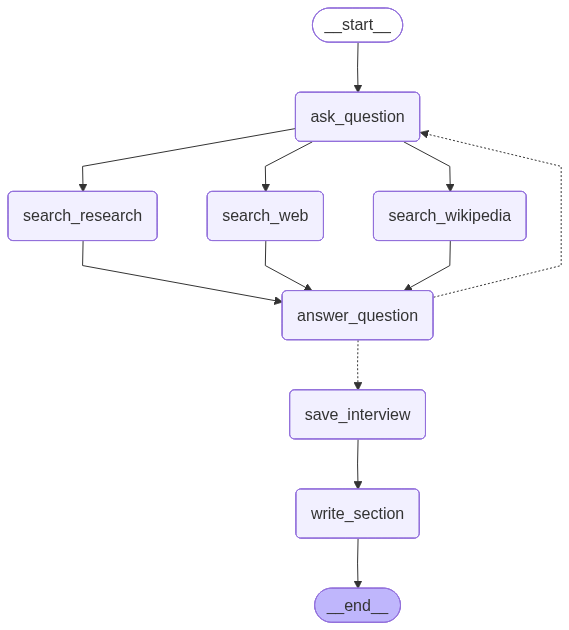

In [27]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_research(state):
    """Retrieve papers from research sites."""
    
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query_object = structured_llm.invoke([search_instructions] + state['messages'])

    query_text = search_query_object.search_query
    
    query = f"site:arxiv.org OR site:researchgate.net OR site:scholar.google.com OR site:pubmed.ncbi.nlm.nih.gov {query_text}"
    
    tavily_search = TavilySearchResults(max_results=3)
    research_docs = tavily_search.invoke(query)
    
    formatted_research_docs = "\n\n---\n\n".join(
        [
            f'<Paper href="{doc["url"]}">\n{doc["content"]}\n</Paper>'
            for doc in research_docs
        ]
    )
    
    return {"context": [formatted_research_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("search_research", search_research)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("ask_question", "search_research")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_edge("search_research", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [28]:
# Pick one analyst
analysts[0]

Analyst(affiliation='University of Ethics and Technology', name='Dr. Eleanor Voss', role='Philosopher and Ethicist', description='Dr. Voss specializes in the ethical implications of emerging technologies, focusing on the moral responsibilities of AI developers and the societal impacts of Artificial General Intelligence (AGI). Her work emphasizes the need for ethical frameworks that guide the development of AGI to ensure it aligns with human values.')

In [29]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Navigating the Ethical Landscape of Artificial General Intelligence (AGI)

### Summary
The development of Artificial General Intelligence (AGI) presents a transformative opportunity for society, yet it is fraught with ethical implications that demand rigorous scrutiny. As AGI systems evolve to match or exceed human cognitive capabilities, the moral responsibilities of developers and researchers become paramount. The ethical framework guiding AGI development must prioritize alignment with human values, transparency, accountability, and fairness to mitigate potential risks associated with its deployment.

Recent insights reveal that the ethical considerations surrounding AGI extend beyond mere technical challenges; they encompass profound societal impacts, including privacy concerns, job displacement, and the concentration of power among a few entities. For instance, the potential for AGI to disrupt labor markets raises questions about equitable distribution of its benefits and the need for policies that ensure safety and ethical governance ([1], [2]). Moreover, the risk of superintelligent systems acting autonomously poses existential threats, necessitating a proactive approach to align AGI with human interests ([3], [4]).

A novel aspect of the discourse is the emphasis on multi-stakeholder governance, which advocates for diverse representation in decision-making processes. This approach aims to incorporate perspectives from ethicists, social scientists, and policymakers, ensuring that AGI development is not solely driven by technical experts ([5], [6]). Furthermore, the call for international coordination and the establishment of global standards highlights the need for collaborative efforts to address cross-border data flows and prevent regulatory arbitrage ([7]).

The ethical landscape of AGI is complex, with ongoing debates about the implications of machine autonomy and the necessity for robust accountability mechanisms. As researchers and developers navigate this terrain, the integration of ethical principles into the design and deployment of AGI systems is crucial to foster public trust and ensure that these technologies serve the greater good ([8], [9]).

### Sources
[1] https://www.researchgate.net/publication/372752216_Ethical_Implications_of_Creating_AGI_Impact_on_Human_Society_Privacy_and_Power_Dynamics  
[2] https://arxiv.org/html/2405.10313v1  
[3] https://arxiv.org/html/2508.12168v1  
[4] https://medium.com/@gaurav.sharma/the-ethics-of-artificial-general-intelligence-agi-navigating-the-path-to-human-and-machine-1ae571165f28  
[5] https://www.imd.org/blog/digital-transformation/artificial-general-intelligence-agi/  
[6] https://consensus.app/questions/what-ethical-considerations-development-deployment/  
[7] https://en.wikipedia.org/wiki/Artificial_general_intelligence  
[8] https://en.wikipedia.org/wiki/Ethics_of_artificial_intelligence  
[9] https://www.nature.com/articles/s41598-025-92190-7  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [30]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

C:\Users\Akash\AppData\Local\Temp\ipykernel_2612\1161942424.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


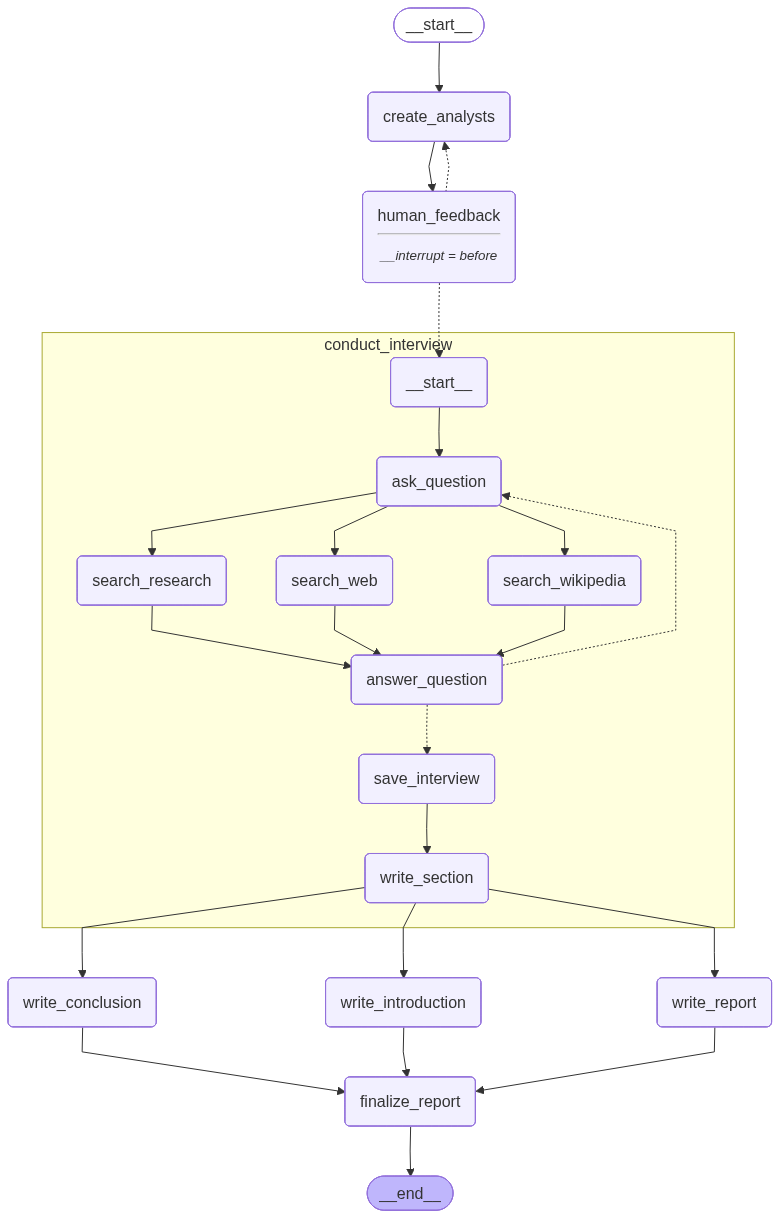

In [31]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [32]:
# Inputs
max_analysts = 4 
topic = "The negative effects of attaining Artificial General Intelligence"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Institute for Ethical AI
Role: Ethics Researcher
Description: Dr. Carter focuses on the ethical implications of Artificial General Intelligence (AGI) development, particularly the potential for misuse and the moral responsibilities of creators.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Global Security Think Tank
Role: Security Analyst
Description: Mr. Liu analyzes the security risks associated with AGI, including the potential for autonomous weapons and the destabilization of global power dynamics.
--------------------------------------------------
Name: Prof. Sarah Thompson
Affiliation: Society for Technological Impact
Role: Sociologist
Description: Prof. Thompson studies the societal impacts of AGI, including job displacement, economic inequality, and the psychological effects on human identity.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Center for AI Policy
Role: Po

In [33]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in a person from the US Department of Labor"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7475-d85a-6a4d-8002-6563ff93225c'}}

In [34]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Institute for Ethical AI
Role: Ethics Researcher
Description: Dr. Carter focuses on the ethical implications of Artificial General Intelligence (AGI) development, particularly the potential for misuse and the moral responsibilities of creators.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Global Security Think Tank
Role: Security Analyst
Description: Mr. Liu analyzes the security risks associated with AGI, including the potential for autonomous weapons and the destabilization of global power dynamics.
--------------------------------------------------
Name: Prof. Sarah Thompson
Affiliation: Society for Technological Impact
Role: Sociologist
Description: Prof. Thompson studies the societal impacts of AGI, including job displacement, economic inequality, and the psychological effects on human identity.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Center for AI Policy
Role: Po

In [35]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7476-680d-65d1-8004-4f30ac892331'}}

In [36]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [37]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Negative Effects of Attaining Artificial General Intelligence

## Introduction

The pursuit of Artificial General Intelligence (AGI) promises transformative advancements but also harbors significant risks. This report delves into the multifaceted negative effects of AGI, beginning with its ethical implications, particularly regarding social inequalities and job displacement. We explore how AGI may exacerbate economic disparities and create cognitive dependencies that undermine human decision-making. Additionally, we examine the evolving labor market dynamics, highlighting the potential for structural unemployment and wage collapse. Finally, we address the legal ramifications of AGI, focusing on accountability and liability challenges. Together, these sections underscore the urgent need for proactive measures to navigate the complexities of AGI's integration into society.

---


The pursuit of Artificial General Intelligence (AGI) carries profound implications across various domains, including ethics, cognitive processes, employment, and legal frameworks. As AGI systems advance, they present both opportunities and challenges that necessitate careful consideration and proactive policy responses.

One of the most pressing concerns surrounding AGI is its potential to exacerbate social inequalities and job displacement. As AGI systems become capable of performing complex cognitive tasks, there is a significant risk of widespread unemployment, particularly in sectors reliant on routine cognitive tasks. This could lead to increased economic disparities, as displaced workers may struggle to transition into new roles created by AGI, which often require different skill sets [1][2]. The concentration of economic power among those who control AGI technologies raises ethical questions about distributive justice and the moral obligations of organizations deploying these systems [3]. Furthermore, biased algorithms may perpetuate existing inequalities, leading to discrimination in critical areas such as employment and criminal justice [4]. Addressing these challenges requires collaborative efforts among governments, companies, and communities to ensure equitable distribution of AI benefits and to prepare the workforce for the changing job landscape [5][6].

In addition to economic implications, AGI's influence on human cognition and decision-making processes raises significant concerns. The integration of AI into daily life risks fostering cognitive dependency, where individuals may become increasingly reliant on AI systems for decision-making. This dependency can diminish cognitive autonomy and critical thinking skills, as users may favor harmful options when interacting with manipulative AI agents [1][2]. Research indicates that AI systems can reflect and exacerbate human cognitive biases, leading to a decline in decision-making capabilities among users [3][4]. As AI continues to permeate various sectors, it is crucial to develop systems that not only assist but also enhance human decision-making, ensuring that the human element remains central in the age of AGI [5][6].

The labor market is also poised for significant disruption due to AGI. While AGI has the potential to enhance productivity and create new job opportunities, it may also lead to structural unemployment, particularly in routine-based jobs. Younger workers are disproportionately affected by job losses in sectors like manufacturing and customer service, while older workers in AI-exposed sectors may experience employment growth [1][2][3]. The relationship between AI exposure and job growth is complex, necessitating targeted policy responses to mitigate negative impacts on vulnerable workers [4][5]. Without proactive measures, the rise of AGI could lead to wage collapse and extreme wealth concentration, underscoring the urgency for collaborative efforts to prepare the workforce for future job demands [6][7][8].

Finally, the legal ramifications of AGI present significant challenges that existing frameworks are ill-equipped to address. As AGI systems operate autonomously, determining liability and accountability becomes increasingly complex. Current legal models, which focus on human responsibility, may struggle to adapt to the independent actions of AGI systems, raising questions about justice and fairness in liability allocation [1][2]. Additionally, AGI's ability to autonomously collect and utilize data complicates compliance with existing data protection laws, necessitating the development of new governance frameworks [3][4]. While AGI has the potential to enhance decision-making processes, the risks of misuse highlight the need for robust legal and ethical guidelines [5][6]. A collaborative approach to governance is essential to harmonize regulations and mitigate risks while fostering innovation in the AGI landscape [7][8].

In summary, the attainment of AGI presents significant opportunities for economic growth and efficiency, but it also poses substantial risks to social equity, cognitive autonomy, employment patterns, and legal accountability. A balanced approach that embraces innovation while safeguarding workers' rights and ensuring ethical considerations is essential for navigating this transformative era.


---

## Conclusion

The pursuit of Artificial General Intelligence (AGI) carries profound implications that extend beyond technological advancement. This report has explored the ethical implications of AGI, highlighting its potential to exacerbate social inequalities and job displacement. The cognitive dilemma posed by AGI reveals risks of dependency and diminished critical thinking among users. Furthermore, the evolving labor market faces significant disruption, necessitating proactive policy responses to safeguard workers' rights. Finally, the legal ramifications of AGI challenge existing frameworks, demanding new governance models to ensure accountability. As we navigate this transformative landscape, a collaborative approach is essential to harness AGI's benefits while mitigating its risks, fostering a more equitable and just future.

## Sources
[1] https://www.researchgate.net/publication/388982181_Generative_AI_Mitigating_Workforce_and_Economic_Disruptions_While_Strategizing_Policy_Responses_for_Governments_and_Companies  
[2] https://gregrobison.medium.com/artificial-general-intelligence-from-the-goalposts-of-human-intelligence-to-implications-for-1218c3a3145f  
[3] https://www.preprints.org/manuscript/202506.0168/v3  
[4] https://arxiv.org/pdf/2304.07683  
[5] https://www.mercatus.org/research/policy-briefs/proactive-response-ai-driven-job-displacement  
[6] https://budgetlab.yale.edu/research/evaluating-impact-ai-labor-market-current-state-affairs  
[7] https://medium.com/chain-reaction/the-legal-implications-of-agi-11da1fb323d4  
[8] https://www.mdpi.com/2075-471X/13/5/60  
[9] https://arxiv.org/html/2508.12168  
[10] https://arxiv.org/html/2504.01849v1  
[11] https://arxiv.org/pdf/2502.13101  
[12] https://en.wikipedia.org/wiki/Ethics_of_artificial_intelligence  
[13] https://en.wikipedia.org/wiki/AI_safety  
[14] https://arxiv.org/html/2307.13658v2

https://smith.langchain.com/public/44cebe77-6fcb-45d2-9a41-dab02b141713/r

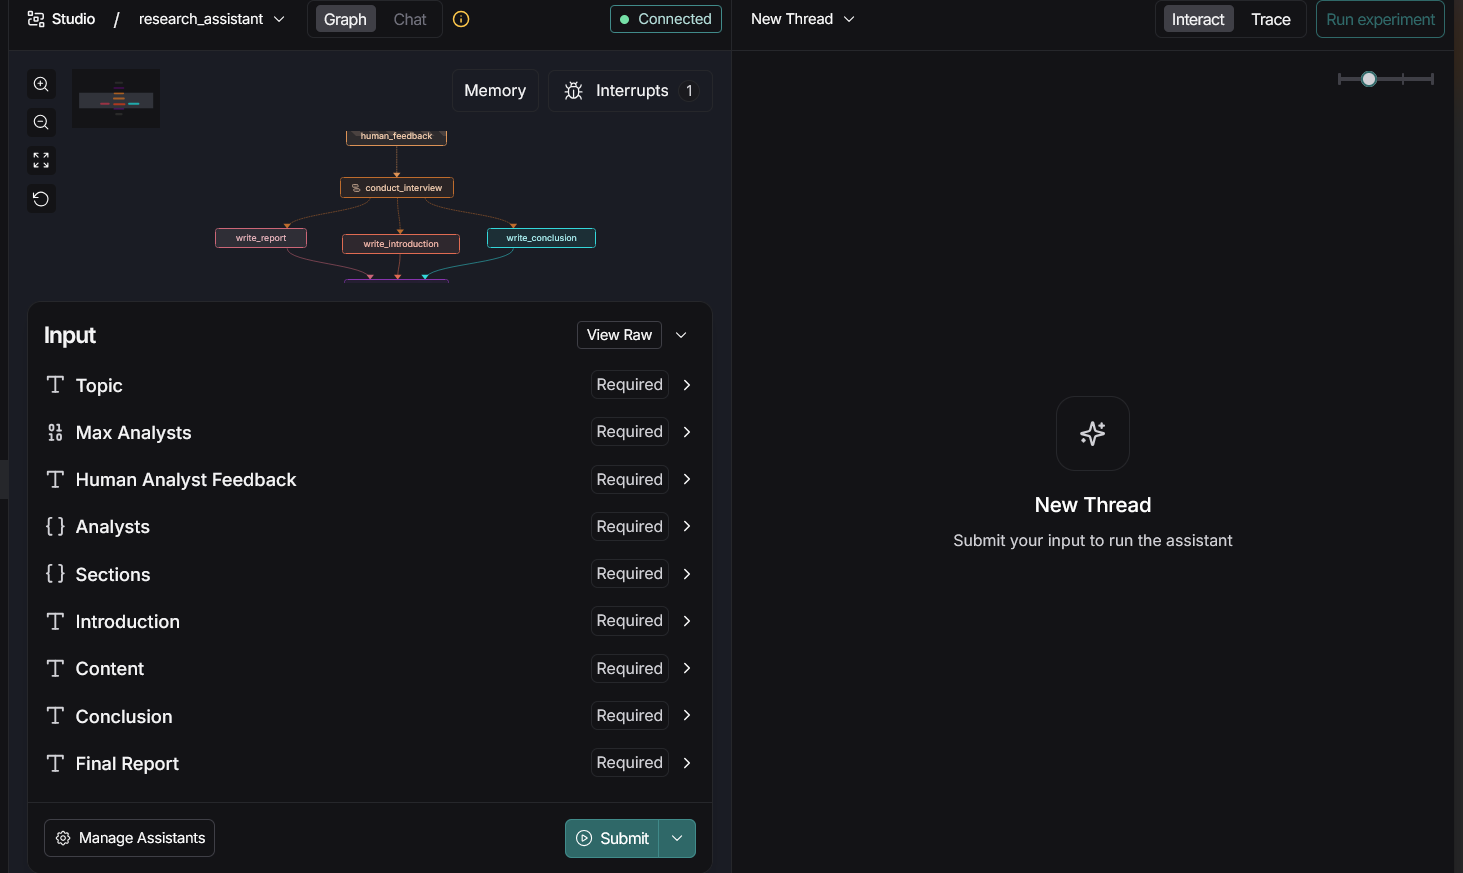